In [1]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath(''))
root = dirname.parent

sys.path.insert(0, str(root))

In [2]:
BATCH_SIZE = 64
WINDOW_SIZE = 10
ENCODER_HIDDEN_STATES = 64
DECODER_HIDDEN_STATES = 64

Y_DIM = 1

DATA = 'nasdaq100_padding.csv'

VALIDATION_RATIO = 0.2

EPOCHS = 100

In [3]:
import numpy as np
import pandas as pd
from typing import Tuple


def read_data(input_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    """
    Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.
    """
    df = pd.read_csv(input_path).iloc[:10000]

    X = df.loc[:, [x for x in df.columns if x != 'NDX']].values

    y = np.array(df['NDX'])

    return X, y

X, Y = read_data(DATA)

Y = Y[:, None]

features = np.concatenate((X, Y), axis=1)

print(features.shape)

(10000, 82)


In [4]:
def get_labels_from_features(features):
    return features[WINDOW_SIZE - 1:, -Y_DIM:]


def split_by_ratio(features):
    length = len(features)
    validation_length = int(VALIDATION_RATIO * length)
    
    return features[:-validation_length], features[-validation_length:]


training_features, validation_features = split_by_ratio(features)

print('training length', len(training_features))
print('validation length', len(validation_features))

training length 8000
validation length 2000


In [5]:
import tensorflow as tf
from get_rolling_window import rolling_window

train_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(training_features, WINDOW_SIZE, 1), 
    get_labels_from_features(training_features)
)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((
    rolling_window(validation_features, WINDOW_SIZE, 1), 
    get_labels_from_features(validation_features)
)).batch(BATCH_SIZE)

train_ds

<BatchDataset shapes: ((None, 10, 82), (None, 1)), types: (tf.float64, tf.float64)>

In [6]:
from da_rnn import DARNN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape

model = DARNN(
    WINDOW_SIZE,
    ENCODER_HIDDEN_STATES,
    DECODER_HIDDEN_STATES,
    Y_DIM
)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy', 'mae', 'mape']
)

In [7]:
feature_batch, label_batch = next(iter(train_ds))

print('feature, label shape', feature_batch.shape, label_batch.shape)

print('prediction shape', model(feature_batch).shape)

model(feature_batch[:1])

feature, label shape (64, 10, 82) (64, 1)
prediction shape (64, 1, 1)


<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[-1.275768]]], dtype=float32)>

In [8]:
save_to = dirname / 'checkpoint.hdf5'

history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[
        # Save checkpoints on best validation loss
        tf.keras.callbacks.ModelCheckpoint(
            save_to,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        # Stop early if the model overfits
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ],
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/100
125/125 [==============================] - 34s 88ms/step - loss: 22009116.3016 - accuracy: 0.0000e+00 - mae: 4691.3106 - mape: 99.1919 - val_loss: 20503292.0000 - val_accuracy: 0.0000e+00 - val_mae: 4528.0259 - val_mape: 94.4898

Epoch 00001: val_loss improved from inf to 20503292.00000, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 2/100
125/125 [==============================] - 6s 45ms/step - loss: 18754333.2698 - accuracy: 0.0000e+00 - mae: 4329.5721 - mape: 91.5594 - val_loss: 15038743.0000 - val_accuracy: 0.0000e+00 - val_mae: 3877.9458 - val_mape: 80.9239

Epoch 00002: val_loss improved from 20503292.00000 to 15038743.00000, saving model to /Users/kael/Codes/ml/tensorflow-2-DA-RNN/notebook/checkpoint.hdf5
Epoch 3/100
125/125 [==============================] - 6s 45ms/step - loss: 12979510.8889 - accuracy: 0.0000e+00 - mae: 3599.1232 - mape: 76.1273 - val_loss: 8686124.0000 - val_accuracy: 0.0000e+00 - val_mae: 2947.1765 - val

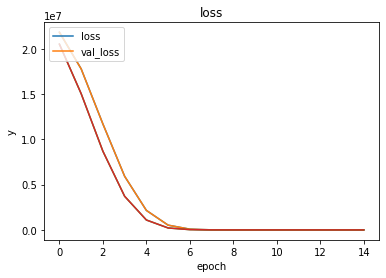

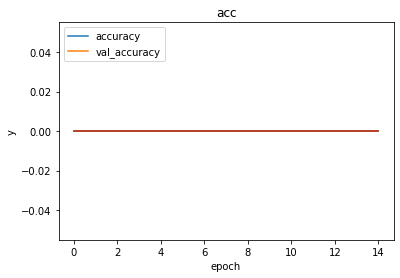

In [9]:
import matplotlib.pyplot as plt


def plot(keys, title='title', ylabel='y'):
    for key in keys:
        plt.plot(history.history[key])
        plt.plot(history.history[key])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    
    plt.legend(keys, loc='upper left')
    
    plt.show()
    
plot(['loss', 'val_loss'], 'loss')
plot(['accuracy', 'val_accuracy'], 'acc')
